In [184]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from sklearn import preprocessing, neighbors, grid_search, cross_validation, decomposition, metrics
from vgg16 import Vgg16
from utils import plots, get_batches, get_data
from keras.preprocessing import image
import pandas as pd

%matplotlib inline

### Problem Statement

**To compare the image recognition performance of K-Nearest Neighbor and Convolutional Neural Networks, specifically the ability to distinguish between cats and dogs**

### Background

#### Asirra dataset

- Asirra = Animal Species Image Recognition for Restricting Access
- Dataset is used as a  CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) or HIP (Human Interactive Proof) to have user identify image 
- used to avoid image recognition attacks
- as computer advanced are made, accuracy rates from "state of the art" algorithms increases
- current leader board on Kaggle for this dataset is `0.98914`, meaning the dataset is no longer "safe from attack" but still useful for benchmarking

#### Computer images
- to a computer an image is represented as one large 3-dimensional array of numbers
- measurements include the pixels (i.e. 224 pixels by 224 pixels) and three color channels Red,Green,Blue (or RGB for short)
- the digital representation of an image consists of _pixel no._ x _pixel no._ x 3 numbers (for the example, a total of 150,528 numbers) 
- each number is an integer that ranges from 0 to 255
- **Question**: how does one turn 30,000 numbers into a single label, such as “cat”?

![rgb](https://www.researchgate.net/profile/Bhupendra_Pratap_Singh/publication/282798184/figure/fig15/AS:283989639221249@1444719814399/Fig-15-Color-image-representation-and-RGB-matrix.png)

---

#### Challenges with image recognition

![image challenges](http://cs231n.github.io/assets/challenges.jpeg)

### Download & Organize Data

#### Directory setup

In [131]:
# path = "data/dogscats/"
path = "data/dogscats/sample/"
model_path = path + 'models/'  # for saving arrays

In [ ]:
# # make a directory for the data and models
# os.makedirs('data/dogscats/sample')
# os.makedirs(path + 'test/unknown')
# if not os.path.exists(model_path): os.mkdir(model_path)

#### Setup unofficial [kaggle-cli](https://github.com/floydwch/kaggle-cli) to download kaggle datasets!

In [ ]:
%%bash
# pip install kaggle-cli
# kg config -g -u [USERNAME] -p [PASSWORD] -c dogs-vs-cats-redux-kernels-edition
# kg download

#### Unzip the data into the correct directories

In [ ]:
%%bash
# pip install unzip
# unzip train.zip -d data/dogscats/.
# unzip test.zip -d data/dogscats/test/unknown/.

#### Distribute data

In [ ]:
%%!
# python /home/ubuntu/nbs/1_Lesson/organize_images.py /home/ubuntu/nbs/1_Lesson/data/dogscats/

In [ ]:
%%bash
# # Use commands below to do additional moving around of data and copying to sample folder
# # count the number of files in a directory
# ls -F |grep -v / | wc -l

# # copy (cp) or move (mv) batches of files (number after 'tail -') between directories
# for file in $(ls -p | grep -v / | tail -500); do cp $file ../../train+valid/dog/; done

#### Take a peek at the data

In [132]:
def get_data(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4):
    batches = gen.flow_from_directory(dirname, target_size=(224,224), class_mode='categorical', 
                                      shuffle=shuffle, batch_size=batch_size)
    return batches

Found 1000 images belonging to 2 classes.


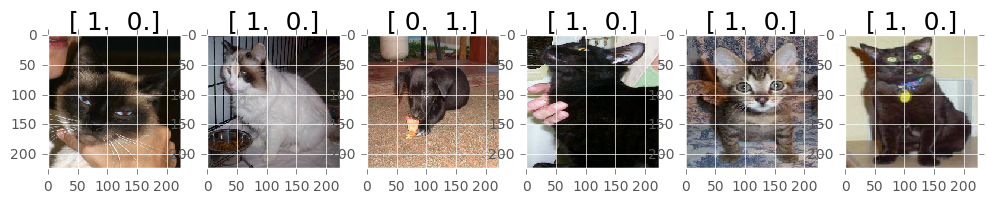

In [133]:
batches = get_batches(path+'train', batch_size=6)
imgs, labels = next(batches)
plots(imgs, titles=labels)

### KNN

#### Considerations

- sample size, _n_ 
    - training dataset: 25,000 images
    - unlabeled, test dataset: 12,500 images
- dimensionality/feature reduction
    - 224 x 224 x 3 = 150,528 features!
- n_neighbors 
- k-folds for cross validation

#### Load images & save image arrays

In [134]:
batch = get_data(path + 'train', batch_size = 600)
X_matrix, c = next(batch)

Found 1000 images belonging to 2 classes.


#### Flatten images

In [135]:
X = X_matrix.reshape(X_matrix.shape[0], 224 * 224 * 3)

#### Split into Train and Test sets

In [136]:
train_X, test_X, train_c, test_c = cross_validation.train_test_split(X, c, test_size=0.2, random_state=0)

In [137]:
print("There are {} features!".format(train_X.shape[1]))

There are 150528 features!


#### Scale and Center features

In [ ]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(train_X)

In [ ]:
train_X = scaler.transform(train_X)

In [ ]:
train_X

#### PCA

In [138]:
pca = decomposition.PCA().fit(train_X)

In [139]:
pca.n_components_

150528

In [140]:
pca.components_.shape

(480, 150528)

#### Explained Variance

In [141]:
normalized_eigenvalues = pca.explained_variance_ratio_

In [142]:
normalized_eigenvalues

array([  1.8047e-01,   1.0766e-01,   7.5764e-02,   5.1995e-02,   3.2108e-02,   2.8042e-02,
         2.4997e-02,   1.8623e-02,   1.7122e-02,   1.6191e-02,   1.4324e-02,   1.2876e-02,
         1.1612e-02,   1.1194e-02,   9.0586e-03,   8.5588e-03,   7.8942e-03,   7.4825e-03,
         6.9149e-03,   6.5937e-03,   6.5177e-03,   5.9942e-03,   5.7734e-03,   5.5043e-03,
         5.3172e-03,   4.9889e-03,   4.8805e-03,   4.7899e-03,   4.5490e-03,   4.4642e-03,
         4.3194e-03,   4.2270e-03,   4.0241e-03,   3.8263e-03,   3.6456e-03,   3.5679e-03,
         3.4533e-03,   3.3780e-03,   3.3207e-03,   3.2224e-03,   3.0809e-03,   2.9859e-03,
         2.9086e-03,   2.8277e-03,   2.7407e-03,   2.6648e-03,   2.6384e-03,   2.6222e-03,
         2.5315e-03,   2.4690e-03,   2.4186e-03,   2.3675e-03,   2.3009e-03,   2.2534e-03,
         2.2371e-03,   2.1625e-03,   2.1159e-03,   2.0905e-03,   2.0752e-03,   1.9864e-03,
         1.9622e-03,   1.9261e-03,   1.8977e-03,   1.8849e-03,   1.8314e-03,   1.8102e-03,

(-1, 200)

(-0.01, 0.19046796321879339)

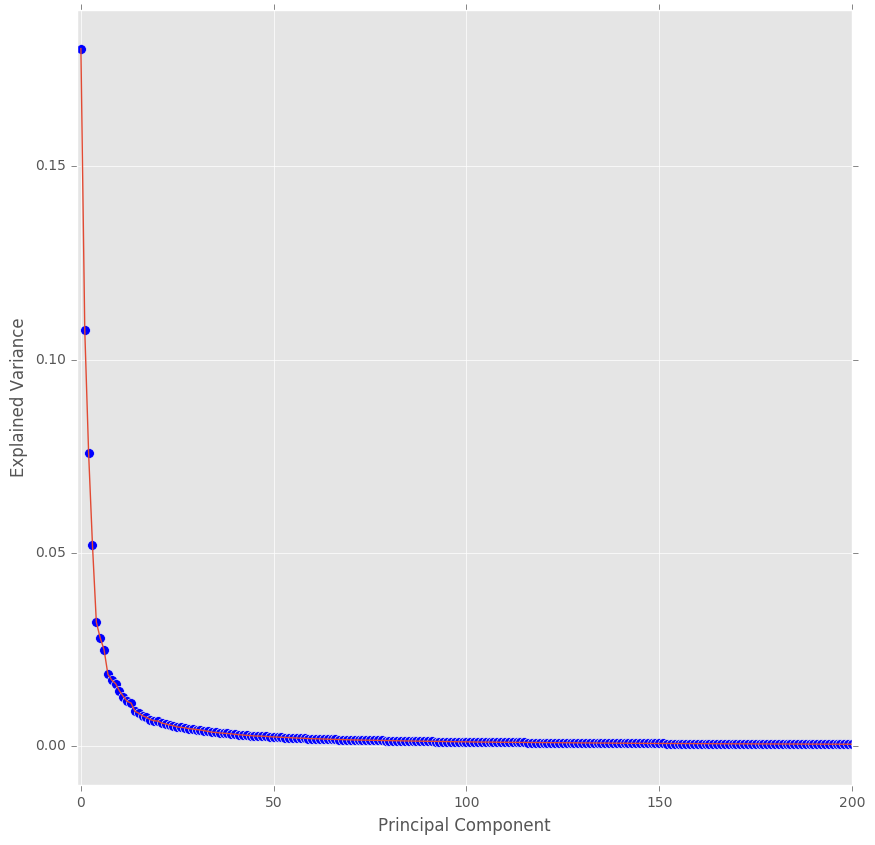

In [143]:
plt.figure(figsize=(10,10))
plt.plot(normalized_eigenvalues)

plt.scatter(x = range(len(normalized_eigenvalues)),
    y = normalized_eigenvalues,
    marker = 'o',
    s = 50)

plt.ylabel('Explained Variance')
plt.xlabel('Principal Component')
# plt.xlim(-1, len(normalized_eigenvalues))
plt.xlim(-1, 200)
plt.ylim(-.01, max(normalized_eigenvalues) + .01)
plt.style.use('ggplot')

In [144]:
cumulated_normalized_eigenvalues = np.cumsum(normalized_eigenvalues)

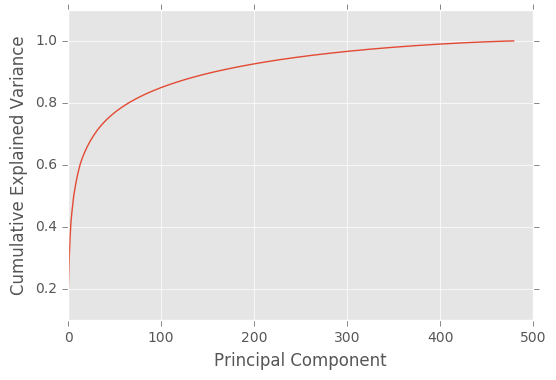

In [146]:
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.plot(cumulated_normalized_eigenvalues)

#### Feature Reduction: n_componenets = 4 

In [147]:
pca = decomposition.PCA(n_components = 4).fit(train_X)

In [148]:
train_X = pca.transform(train_X)

In [149]:
train_X.shape

(480, 4)

#### Hyperparameter Determinations

In [150]:
k_cv = 10 # 10-fold CV
k_nn = range(1, int(train_X.shape[0] * (k_cv - 1) / k_cv)) # k-NN

gs = grid_search.GridSearchCV(
    estimator = neighbors.KNeighborsClassifier(weights='distance'),
    param_grid = {'n_neighbors': k_nn, 'weights': ['uniform', 'distance']},
    cv = cross_validation.KFold(train_X.shape[0], n_folds = k_cv)
)

gs.fit(train_X, train_c)

score_df = pd.DataFrame({'k': [score.parameters['n_neighbors'] for score in gs.grid_scores_],
        'weights': [score.parameters['weights'] for score in gs.grid_scores_],
        'score': [score.mean_validation_score for score in gs.grid_scores_]})

score_df

GridSearchCV(cv=sklearn.cross_validation.KFold(n=480, n_folds=10, shuffle=False, random_state=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...19, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

,k,score,weights
0,1,0.529167,uniform
1,1,0.529167,distance
2,2,0.279167,uniform
3,2,0.529167,distance
4,3,0.527083,uniform
5,3,0.518750,distance
6,4,0.339583,uniform
7,4,0.512500,distance
8,5,0.502083,uniform
9,5,0.510417,distance


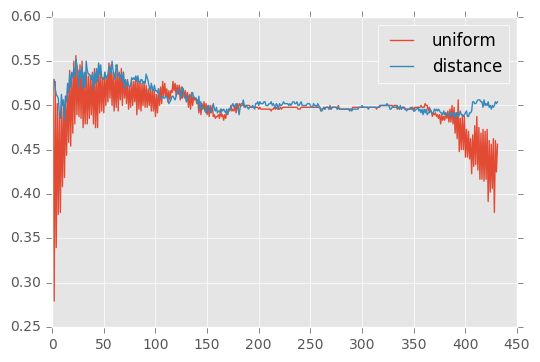

In [151]:
score_uniform_df = score_df[score_df.weights == 'uniform']
plt.plot(score_uniform_df.k, score_uniform_df.score, label = 'uniform')

score_distance_df = score_df[score_df.weights == 'distance']
plt.plot(score_distance_df.k, score_distance_df.score, label = 'distance')

plt.legend()

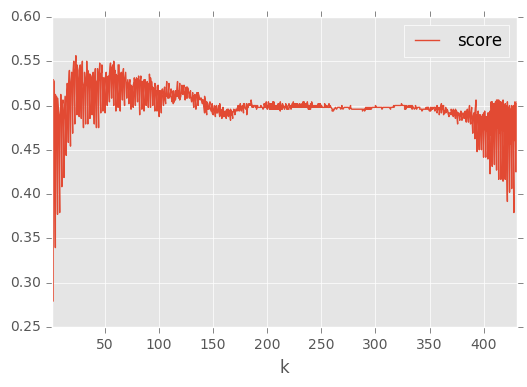

In [152]:
score_df.plot(x = 'k', y = 'score')

In [153]:
score_df[score_df.score == score_df.score.max()]

,k,score,weights
44,23,0.55625,uniform


In [154]:
gs.best_params_

{'n_neighbors': 23, 'weights': 'uniform'}

In [155]:
gs.best_score_

0.55625000000000002

In [156]:
gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=23, p=2,
           weights='uniform')

k = 23 produces the best result with an accuracy of 55.6%.

#### Model fitting

In [158]:
model = neighbors.KNeighborsClassifier(n_neighbors = gs.best_params_['n_neighbors'], weights = gs.best_params_['weights']).\
    fit(train_X, train_c)

##### Training

Accuracy

In [159]:
training_accuracy = model.score(train_X, train_c)

In [160]:
training_accuracy

0.59166666666666667

In [161]:
print("The KNN model has a training accuracy {} %.".format(training_accuracy * 100.))

The KNN model has a training accuracy 59.1666666667 %.


Misclassification

In [162]:
print("The KNN model has a training error of {} %".format((1 - training_accuracy) * 100))

The KNN model has a training error of 40.8333333333 %


In [163]:
c_hat = model.predict(train_X)

In [164]:
(c_hat != train_c).sum()

392

In [165]:
pd.crosstab(c_hat[:,0], train_c[:,0], rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0.0,1.0
Hypothesized Class,,
0.0,177,134
1.0,62,107


##### Testing

In [166]:
pca = decomposition.PCA(n_components = 4).fit(test_X)
test_X = pca.transform(test_X)

In [167]:
testing_accuracy = model.score(test_X, test_c)

In [168]:
print("The KNN model has a testing accuracy {} %.".format(testing_accuracy * 100.))

The KNN model has a testing accuracy 50.0 %.


In [169]:
print("The KNN mdel has a testing error of {} %".format((1 - testing_accuracy) * 100))

The KNN mdel has a testing error of 50.0 %


In [170]:
c_hat_test = model.predict(test_X)

In [171]:
(c_hat_test != test_c).sum()

120

In [172]:
pd.crosstab(c_hat_test[:,0], test_c[:,0], rownames = ['hypothesized class'], colnames = ['true class'])

true class,0.0,1.0
hypothesized class,,
0.0,36,38
1.0,22,24


#### Model Analysis

In [174]:
pca = decomposition.PCA(n_components = 4).fit(X)

In [176]:
X = pca.transform(X)

In [177]:
model.score(X, c)

0.55166666666666664

In [178]:
c_hat = model.predict(X)

In [196]:
pd.crosstab(c_hat[:,0], c[:,0], rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,0.0,1.0
Hypothesized Class,,
0.0,201,173
1.0,96,130


In [203]:
print("Overall, the KNN classifier is correct {}% of the time".format(model.score(X, c) * 100.))

Overall, the KNN classifier is correct 55.1666666667% of the time


In [200]:
print("When the KNN classifier is a cat, it predicts 'cat' {}% of the time (TPR/Sensitivity)".format(130./(130 + 96) * 100))

When the KNN classifier is a cat, it predicts 'cat' 57.5221238938% of the time (TPR/Sensitivity)


In [201]:
print("When the KNN classifier is NOT a cat, it predicts 'cat' {}% of the time (FPR/Fall-out)".format(96./(201 + 96) * 100))

When the KNN classifier is NOT a cat, it predicts 'cat' 32.3232323232% of the time (FPR/Fall-out)


In [202]:
print("Overall, the KNN classifier is wrong {}% of the time".format((96. + 173)/(201+96+173+130) * 100))

Overall, the KNN classifier is wrong 44.8333333333% of the time


#### AUC/ROC curve

(0, 1.01)

(0, 1.01)

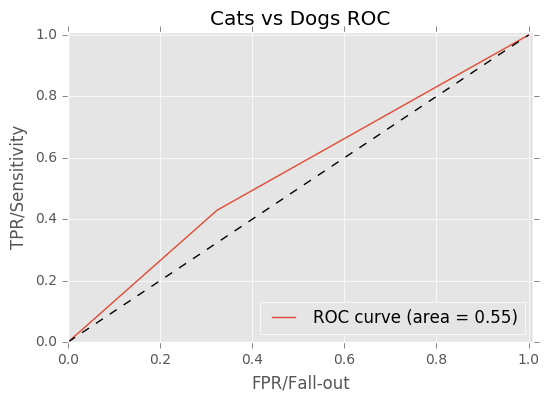

In [192]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(c[:,0], c_hat[:,0])

plt.figure()
plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1.01])
plt.ylim([0, 1.01])
plt.xlabel('FPR/Fall-out')
plt.ylabel('TPR/Sensitivity')
plt.title("Cats vs Dogs ROC")
plt.legend(loc = 'lower right')
plt.show()

The ROC curve illustrates the poor quality of this classifier.

In [194]:
metrics.roc_auc_score(c, c_hat)

0.55290529052905291

#### Final kNN model

```
batch = get_data(path + 'full_mini', batch_size = 600)
X, c = next(train_batch)
X = X_matrix.reshape(X_matrix.shape[0], 224 * 224 * 3)
train_X, test_X, train_c, test_c = cross_validation.train_test_split(X, c, test_size=0.2, random_state=0)
pca = decomposition.PCA(n_components = 4).fit(train_X)
train_X = pca.transform(train_X)

model = neighbors.KNeighborsClassifier(n_neighbors = 23, weights = 'uniform').\
    fit(train_X, train_c)

model.score(X, c)
```

### CNN

#### What is CNN?

- Convolutional Neural Networks
- machine learning technique modeled after the animal visual cortex or "human vision"
- a model that trains computers to "see"

![cnn](https://adeshpande3.github.io/assets/Cover.png)

_source https://adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/ _

#### Vgg16 model

- a model that has been trained to recognize 1,000 categories of images
- won the 2014 Imagenet compeition (the Olympics of computer vision) by the Visual Geometry Group from University of Oxford (http://www.robots.ox.ac.uk/~vgg/research/very_deep/)


Vgg16 layers:

![layers](http://cs231n.github.io/assets/cnn/weights.jpeg)

_source: http://cs231n.github.io/convolutional-networks/ _

Better, more interactive example found here: http://setosa.io/ev/image-kernels/

---

##### Predicting Category

- Instantiate Vgg16 class

In [207]:
vgg = Vgg16() 

- Grab a few images at a time for training and validation.
    - No larger than 64 is recommended -- may run into OMM issues
    - Images in subdirectories based on category

In [208]:
batch_size=6
batches = vgg.get_batches(path+'train', batch_size=batch_size) # 
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2) # 

Found 1000 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


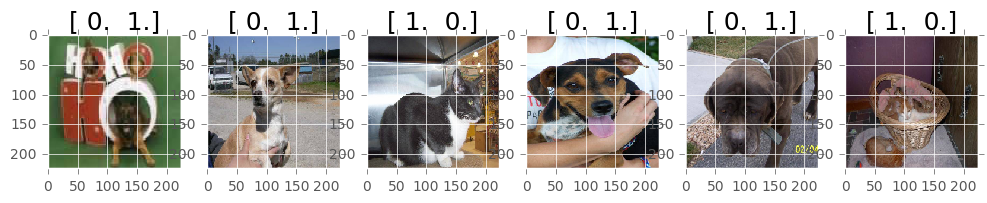

In [209]:
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [210]:
vgg.predict(imgs, True)

(array([ 0.08,  0.17,  0.15,  0.38,  0.66,  0.44], dtype=float32),
 array([577, 227, 700, 237, 243, 431]),
 [u'gong',
  u'kelpie',
  u'paper_towel',
  u'miniature_pinscher',
  u'bull_mastiff',
  u'bassinet'])

- Vgg16's predict() function returns probabilities, category indexes, and category names for each image's VGG prediction
- But since I just want the prediction as to whether the image is of a cat or a dog, I need to “finetune” the model

- Calling finetune() modifies the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.
 - With finetuning I only select a subset of parameters to train and leave the rest untouched.  I added this image as an example of the deeper layers that finetuning might subset, as opposed to the lower-level layers that detect edges and curves. 
 - Below are examples of some of the 'deeper' levels on which the model might select based on finetuning

![fine_tuning](https://adeshpande3.github.io/assets/deconvnet2.png)

_source: https://adeshpande3.github.io/adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html _

In [211]:
batch_size=64
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size)

Found 1000 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


In [212]:
# want the model's validation accurancy to perform better than the training
# loss
vgg.finetune(batches) 

- Fit the parameters of the model using the training data, reporting the accuracy on the validation set after every epoch. (An epoch is one full pass through the training data.)

In [213]:
vgg.fit(batches, val_batches, nb_epoch=1)

Epoch 1/1
1000/1000 [==============================] - 31s - loss: 1.2076 - acc: 0.9020 - val_loss: 0.4271 - val_acc: 0.9720


Now testing out the model on a small batch of images.  

In [214]:
batch_size=6
batches = vgg.get_batches(path+'train', batch_size=batch_size) # 
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2) # 

Found 1000 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


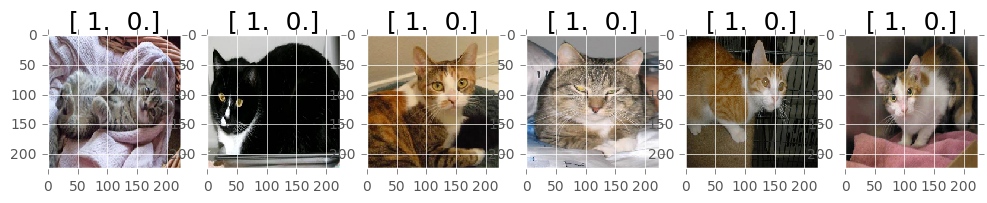

In [215]:
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [216]:
vgg.predict(imgs, True)

(array([ 1.,  1.,  1.,  1.,  1.,  1.], dtype=float32),
 array([0, 0, 0, 0, 0, 0]),
 [u'tench', u'tench', u'tench', u'tench', u'tench', u'tench'])

After finetuning and fitting the model, I now have a model with model a training and validation/testing accuracy of 90 and 97%, respectively.  The loss is high due to it being a small training set, and I could also increase the epochs (number of complete run throughs of the entire dataset to improve the weights.)

### Summary

Model  | Training Accuracy | Testing Accuracy |
------------- | -------------
KNN  | 0.59166666666666667 | 40.8333333333
CNN  | 0.9020 | 0.9720



---

#### KNN

Pros  | Cons
------------- | -------------
Easy to implement  | High testing computational cost 
Low training computational cost | Good only in some settings (low-dimensional data)
  | Images are more a function of general color distribution or background 
  | focus on raw pixels




#### CNN

Pros  | Cons
------------- | -------------
Low testing computational cost  | More difficult to implement 
Very generalizable   | High testing computational cost
Focus on pattern recognition  | 
Less sensitive to image variations |

---